## Quant Finance: Statistical Arbitrage Strategy 
In this research notebook we will backtest a statistical arbitrage trading/investing strategy. We will explore statistical tests such as the Engle-Granger cointegration test and the Augmented Dickey-Fuller test to find stock pairs exhibiting a long-run, and mean-reverting relationship. This will be the basis of our statistical arbitrage stragey.

For a great introductory tutorial in pairs trading with python, check out Auquan's blog: https://medium.com/auquan/mean-reversion-simple-trading-strategies-part-1-a18a87c1196a

### 1. Data Importation & Processing
In this section we will import our data set using the Yahoo Finance API, and we will create a stock close prices dataframe, returns dataframe, and cumulative returns dataframe.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

from statsmodels.tsa.stattools import adfuller, coint

In [2]:
# Specifying list of stocks, start date, and end date
stocks = ['FB', 'AAPL', 'AMZN', 'NFLX', 'GOOGL', 'TSLA', 'KO', 'PEP', 'UPS', 'FDX', 'BA', 'MSFT']
start = '2018-01-01'
end = '2021-01-01'

# Download stock data from Yahoo Finance API
data = yf.download(stocks, start = start, end = end)
# Create new dataframe with close prices of selected stocks
df = data['Adj Close']
# Inspect first 5 rows of data set
df.head()

[*********************100%***********************]  12 of 12 completed


,AAPL,AMZN,BA,FB,FDX,GOOGL,KO,MSFT,NFLX,PEP,TSLA,UPS
Date,,,,,,,,,,,,
2018-01-02,41.380238,1189.010010,282.886383,181.419998,246.582428,1073.209961,40.913391,82.194328,201.070007,106.976776,64.106003,111.274971
2018-01-03,41.373032,1204.199951,283.801239,184.669998,249.664749,1091.520020,40.823551,82.576843,205.050003,106.695877,63.450001,113.740356
2018-01-04,41.565216,1209.589966,282.724396,184.330002,253.551086,1095.760010,41.398529,83.303658,205.630005,107.221428,62.924000,114.478165
2018-01-05,42.038452,1229.140015,294.322296,186.850006,254.546661,1110.290039,41.389545,84.336464,209.990005,107.529510,63.316002,114.829094
2018-01-08,41.882305,1246.869995,295.570740,188.279999,257.169403,1114.209961,41.326656,84.422516,212.050003,106.913345,67.281998,116.223724


In [3]:
# Creating a daily stock returns dataframe
rets = df.pct_change().dropna()
# Creating cumulative returns dataframe
cuml_rets = rets.cumsum()
cuml_rets

,AAPL,AMZN,BA,FB,FDX,GOOGL,KO,MSFT,NFLX,PEP,TSLA,UPS
Date,,,,,,,,,,,,
2018-01-03,-0.000174,0.012775,0.003234,0.017914,0.012500,0.017061,-0.002196,0.004654,0.019794,-0.002626,-0.010233,0.022156
2018-01-04,0.004471,0.017251,-0.000560,0.016073,0.028066,0.020946,0.011889,0.013455,0.022623,0.002300,-0.018523,0.028643
2018-01-05,0.015856,0.033414,0.040462,0.029744,0.031993,0.034206,0.011672,0.025854,0.043826,0.005173,-0.012293,0.031708
2018-01-08,0.012142,0.047839,0.044703,0.037397,0.042296,0.037736,0.010152,0.026874,0.053636,-0.000557,0.050345,0.043853
2018-01-09,0.012027,0.052514,0.071400,0.035220,0.038909,0.036462,0.015152,0.026194,0.040714,0.000206,0.042259,0.043389
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,1.335418,1.150229,0.220841,0.608882,0.322435,0.617956,0.338107,1.143166,1.211799,0.385506,3.007007,0.576963
2020-12-24,1.343130,1.146280,0.209279,0.606234,0.315454,0.621387,0.344889,1.150993,1.210808,0.390007,3.031451,0.574357
2020-12-28,1.378896,1.181351,0.204398,0.642135,0.293580,0.644338,0.358362,1.160914,1.220828,0.402760,3.034352,0.569536


### 2. Statistical Tests & Analysis
In this section we will perform the augmented Engle-Granger two-step cointegration test on our selection of stocks to find stock pairs with a long-run cointegrating relationship. Finding cointegrated pairs is a necessary pre-requisite for our mean-reverting trading strategy. 

First, let's create a simple function that will perform this test on all combinations of our stocks in an attempt to find cointegrated stocks.

In [4]:
# Creating a function that will find cointegrated pairs
def cointegrated_pairs(df):

    n_stocks = len(df.columns)
    tickers = df.columns
    coint_pairs = []
    
    for i in range(n_stocks):
        for j in range(i+1, n_stocks):
            P1 = df[tickers[i]]
            P2 = df[tickers[j]]
            coint_test = coint(P1, P2)
            p_value = coint_test[1]
            if p_value < 0.05:
                coint_pairs.append((tickers[i], tickers[j]))

    return coint_pairs

In [5]:
print('The stock pairs with a long-run cointegrating relationship are: ', cointegrated_pairs(df))

The stock pairs with a long-run cointegrating relationship are:  [('AAPL', 'GOOGL'), ('FB', 'GOOGL')]


- As we can see from the augmented Engle-Granger two-step cointegration test above, Apple & Google, and Facebook & Google are the two stock pairs that have a long-run cointegrating relationship over our sampling period.

Now that we've found our cointegrating pairs, let's perform another cointegration test on these specific pairs to inspect the respective t-statistics and p-values of both combinations.

In [6]:
# Inspecting the cointegrating relationship between Apple & Google
ticker_1 = df['AAPL']
ticker_2 = df['GOOGL']

t_stat, pvalue, critical_vals = coint(ticker_1, ticker_2)

print('The cointegration t-stat for Apple & Google is: ', t_stat)
print('The critical values for Apple & Google are: ', critical_vals)
print('The cointegration test p-value for Apple & Google is: ', pvalue)

The cointegration t-stat for Apple & Google is:  -3.7563556008055516
The critical values for Apple & Google are:  [-3.91102404 -3.34424558 -3.05007972]
The cointegration test p-value for Apple & Google is:  0.015482927153233858


In [7]:
# Inspecting the cointegrating relationship between Facebook & Google
ticker_1 = df['FB']
ticker_2 = df['GOOGL']

t_stat, pvalue, critical_vals = coint(ticker_1, ticker_2)

print('The cointegration t-stat for Facebook & Google is: ', t_stat)
print('The critical values for Facebook & Google are: ', critical_vals)
print('The cointegration test p-value for Facebook & Google is: ', pvalue)

The cointegration t-stat for Facebook & Google is:  -3.3564579828625933
The critical values for Facebook & Google are:  [-3.91102404 -3.34424558 -3.05007972]
The cointegration test p-value for Facebook & Google is:  0.04742204851384935


- The p-value for Apple & Google is 0.015, while the p-value for Facebook & Google is 0.047. According to the Engle-Granger test, both of these are statistically significant, and we can reject the null hypothesis that there is no cointegration between these respective pairs. We can therefore determine that there is a cointegrating relationship.

- As the p-value for the first test is smaller than that of the second test, we can assume that Apple & Google stock prices likely have a slightly stronger cointegrating relationship than Facebook & Google.

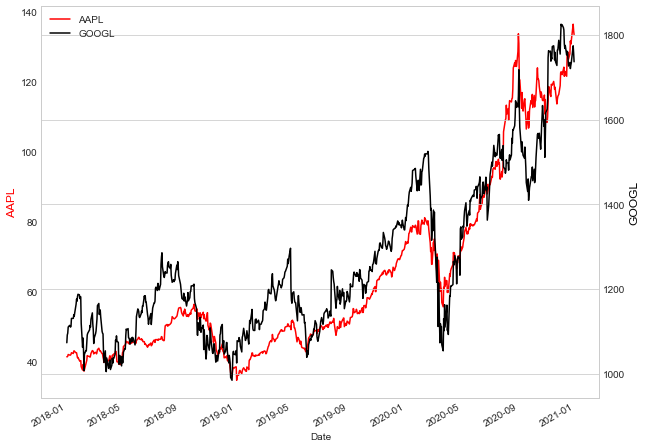

In [8]:
# Plotting close prices of Apple (left) and Google (right)
plt.figure(figsize=(10,8))
ax1 = df['AAPL'].plot(color = 'red')
ax2 = df['GOOGL'].plot(secondary_y=True, color = 'black')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

ax1.set_ylabel('AAPL', color = 'red', fontsize=12)
ax2.set_ylabel('GOOGL', color = 'black', fontsize=12)

plt.legend(h1+h2, l1+l2, fontsize=10) 

plt.show()

- In this plot, the daily close prices of Apple are plotted on the left y-axis, and the daily close prices of Google are plotted on the right y-axis. We can see that both stocks have a long-term trend and price movement relationship.

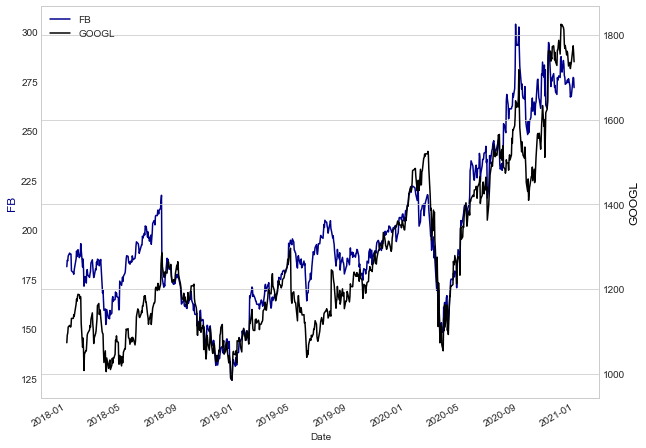

In [9]:
# Plotting close prices of Facebook (left) and Google (right)
plt.figure(figsize=(10,8))
ax1 = df['FB'].plot(color = 'darkblue')
ax2 = df['GOOGL'].plot(secondary_y=True, color = 'black')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

ax1.set_ylabel('FB', color = 'darkblue', fontsize=12)
ax2.set_ylabel('GOOGL', color = 'black', fontsize=12)

plt.legend(h1+h2, l1+l2, fontsize=10) 

plt.show()

- In this plot, the daily close prices of Facebook are plotted on the left y-axis, and the daily close prices of Google are plotted on the right y-axis.

- From both the first and second plots, we can clearly see that when the prices of these stocks diverge from each other, they tend to eventually revert back towards each other over time. 

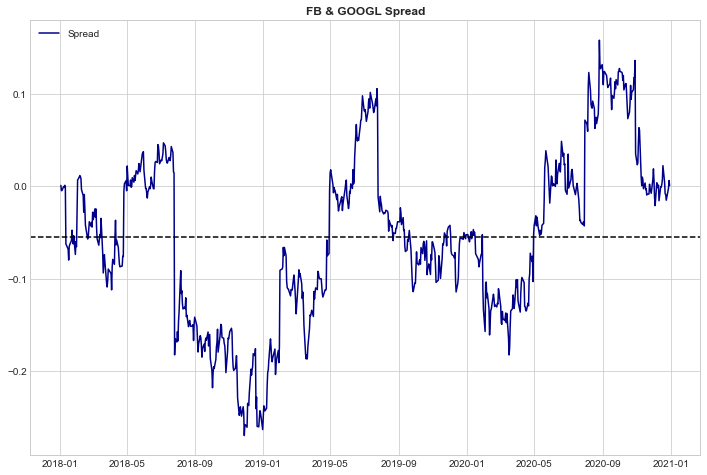

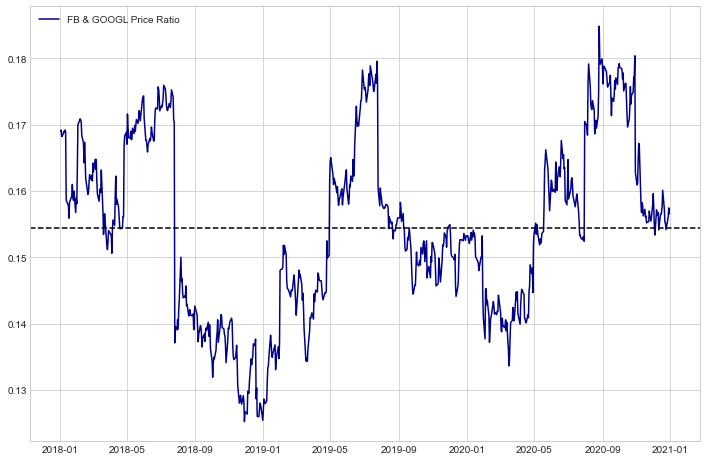

In [10]:
# Calculate the spread of our selected pair
spread = cuml_rets['FB'] - cuml_rets['GOOGL']

plt.figure(figsize=(12,8))
plt.plot(spread, color='darkblue')
plt.title('FB & GOOGL Spread', weight = 'bold')
plt.legend(['Spread'], loc = 'upper left')
plt.axhline(spread.mean(), color='black', linestyle='--');

# Price ratio plot
price_ratio = df['FB']/df['GOOGL']
plt.figure(figsize=(12,8))
plt.plot(price_ratio, color='darkblue')
plt.legend(['FB & GOOGL Price Ratio'])
plt.axhline(price_ratio.mean(), color='black', linestyle='--');

Now that we've used the Engle-Granger test for cointegration, and calculated the spread of Facebook & Google close prices, let's test for stationarity of the spread to see whether or not our time series exhibits a unit-root process. We can test for stationarity by using the Augmented Dickey-Fuller (ADF) test.

Here, we will look for a p-value less than 5% to reject the null hypothesis that there is a unit root. If so, we can infer from the alternative hypothesis that our spread time series is stationary. In other words, in a stationary time series, the data contains no trend, has constant variance over time, a constant autocorrelation, and no seasonality.

### Augmented Dickey-Fuller Stationarity Test

In [11]:
adf = adfuller(price_ratio)

print('The t-stat of the spread is:', adf[0])
print('The critical values are:', adf[4])
print('The p-value of the spread is:', adf[1])

The t-stat of the spread is: -2.917882749891201
The critical values are: {'1%': -3.439052522969989, '5%': -2.8653808299915013, '10%': -2.5688152592363274}
The p-value of the spread is: 0.04330764686349167


- The p-value is 0.043 < alpha = 0.05. Therefore, we can reject the null hypothesis and conclude that the spread is stationary (i.e. the spread contains no trend, constant variance, constant autocorrelation, and no periodic fluctuations/seasonality).

### Z-Score
For our statistical arbitrage strategy, we will use the price ratio between Facebook and Google close prices. We can now calculate a z-score with this new data series, to show the deviation from the mean over time measured in standard deviations.  

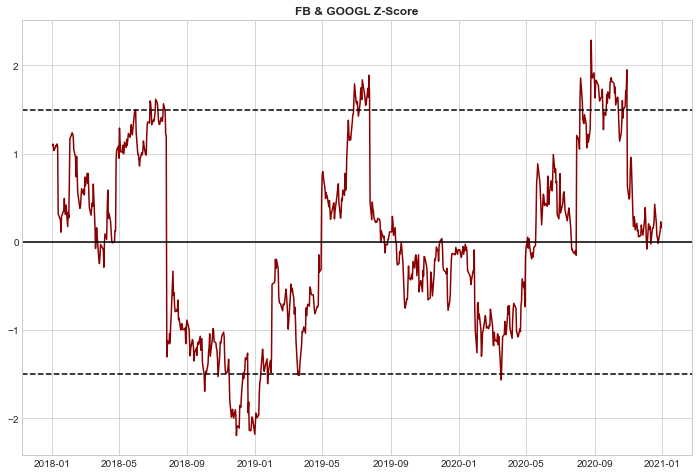

In [12]:
z_score = (price_ratio - price_ratio.mean()) / np.std(price_ratio)

plt.figure(figsize=(12,8))
plt.plot(z_score, color = 'darkred')
plt.title('FB & GOOGL Z-Score', weight = 'bold')
plt.axhline(1.5, color = 'black', linestyle = '--')
plt.axhline(color = 'black')
plt.axhline(-1.5, color = 'black', linestyle = '--');

### 3. Trading Strategy Backtest

Let's create a very simple trading strategy backtest and evaluate this on the Facebook/Google stock pair. In terms of the trading logic, we will go long the spread when the z-score is less than 1, short sell when the z-score is greater than 1, and liquidate all positions when the z-score is between -0.25 and 0.25.

In [13]:
# Start with no money and no positions
portfolio = 0
count = 0

# Statistical arbitrage trading logic
for i in range(len(spread)):
    # Go short if z-score is greater than 1
    if z_score[i] > 1:
        portfolio += spread[i]
        count -= 1
    # Go long if z-score is less than 1
    elif z_score[i] < -1:
        portfolio -= spread[i]
        count += 1
    # liquidate holdings if z-score falls between -0.25 and 0.25
    elif abs(z_score[i]) < 0.25:
        portfolio += count*spread[i]
        count = 0

# Printing the portfolio value of our backtest
print(portfolio)

31.083900817056588


Our statistical arbitrage strategy appears to be profitable. While this is a nice sign, it's important to note that, in isolation, these results don't mean much due to the limited sample size in terms of stocks selected, and limited time series data used. Such an approach is also prone to overfitting and data mining.

### 4. Conclusion
This research notebook provided an insight into the area of statistical arbitrage in quantitative finance. We delved into the statistical methodology behind finding cointegrated pairs through the Engle-Granger test, and determining stationarity in our spread (or the difference between our pair's stock prices) with the Augmented Dickey-Fuller test.

While this research provides a good introduction to statistical arbitrage, there are plenty of opportunities for further development. In practice, in order to create a robust trading algorithm, we would want to be cautious of overfitting and data mining. In terms of expedient opportunities for research development, the first steps I would take would involve:

- Performing cointegration tests on a broader range of securities - from U.S. and international equity markets, exploring exotic instruments, exchange-traded-funds, etc. 

- Developing a more sophisticated trading algorithm. Our strategy backtest was relatively simple, and not robust enough for a fully-deployed trading algorithm - it was merely for presentation and educational purposes. 

- A common approach in statistical arbitrage, which could be included in the algorithm, would be to include moving averages and kalman filters to smooth out the signal in an attempt to reduce high-frequency noise in the spread time series.